# XGBoost

In [2]:
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import classification_report

from model_utils import calc_gini_coef, plot_pr_curve, plot_roc_curve

In [49]:
from model_utils import split_dataset, split_dataset_v2

# CLIENT_PATH = '../data/initial/CLIENTS.csv'
# FEATURES_PATH = '../data/features/features_no_row_delete_inner_join.csv'
# X_train, X_valid, X_test, y_train, y_valid, y_test = split_dataset(CLIENT_PATH, FEATURES_PATH, valid_size=0.2)

# FEATURES_PATH = '../data/features/features_auto_v6.csv'
# FEATURES_PATH = '../data/features_selected/features_v6_filtered_v4.csv'
# FEATURES_PATH = '../data/features_selected/features_v6_embedded_v4.csv'
FEATURES_PATH = '../data/features_selected/features_v6_wrappered_v6.csv'

X_train, X_valid, X_test, y_train, y_valid, y_test = split_dataset_v2(FEATURES_PATH, valid_size=0.2)

In [50]:
# noinspection PyTypeChecker
model = xgb.XGBClassifier(
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=3,
    min_child_weight=10,
    reg_alpha=1.0,
    reg_lambda=2.0,
    subsample=0.7,
    colsample_bytree=0.5,
    objective='binary:logistic',
    scale_pos_weight=3,
    n_jobs=6,
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=50,
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=100,
)

[0]	validation_0-logloss:0.68659	validation_1-logloss:0.68663
[100]	validation_0-logloss:0.58891	validation_1-logloss:0.59007
[200]	validation_0-logloss:0.56123	validation_1-logloss:0.56578
[300]	validation_0-logloss:0.54589	validation_1-logloss:0.55335
[400]	validation_0-logloss:0.53621	validation_1-logloss:0.54721
[500]	validation_0-logloss:0.52865	validation_1-logloss:0.54301
[600]	validation_0-logloss:0.52218	validation_1-logloss:0.53989
[700]	validation_0-logloss:0.51709	validation_1-logloss:0.53781
[800]	validation_0-logloss:0.51224	validation_1-logloss:0.53677
[900]	validation_0-logloss:0.50760	validation_1-logloss:0.53527
[1000]	validation_0-logloss:0.50326	validation_1-logloss:0.53393
[1100]	validation_0-logloss:0.49942	validation_1-logloss:0.53311
[1200]	validation_0-logloss:0.49548	validation_1-logloss:0.53191
[1300]	validation_0-logloss:0.49145	validation_1-logloss:0.53113
[1400]	validation_0-logloss:0.48840	validation_1-logloss:0.53057
[1500]	validation_0-logloss:0.48492	v

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,'logloss'


In [57]:
# y_true = y_train
# y_pred_proba = model.predict_proba(X_train)[:, 1]
y_true = y_valid
y_pred_proba = model.predict_proba(X_valid)[:, 1]
# y_true = y_test
# y_pred_proba = model.predict_proba(X_test)[:, 1]

Gini Coefficient:  0.5889722452904409


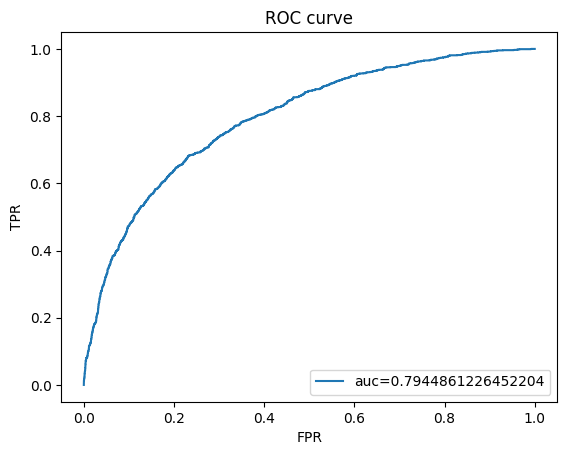

In [58]:
gini_coef = calc_gini_coef(y_true, y_pred_proba)
print('Gini Coefficient: ', gini_coef)

plot_roc_curve(y_true, y_pred_proba)

In [42]:
y_pred = (y_pred_proba >= 0.5).astype(int)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      4175
           1       0.52      0.68      0.59      1370

    accuracy                           0.77      5545
   macro avg       0.70      0.74      0.71      5545
weighted avg       0.79      0.77      0.78      5545



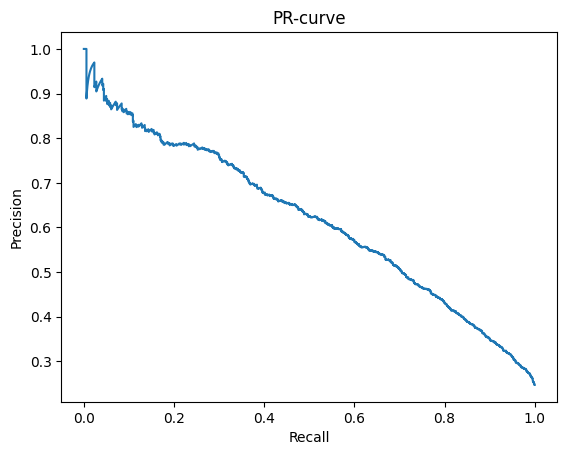

In [43]:
plot_pr_curve(y_true, y_pred_proba)

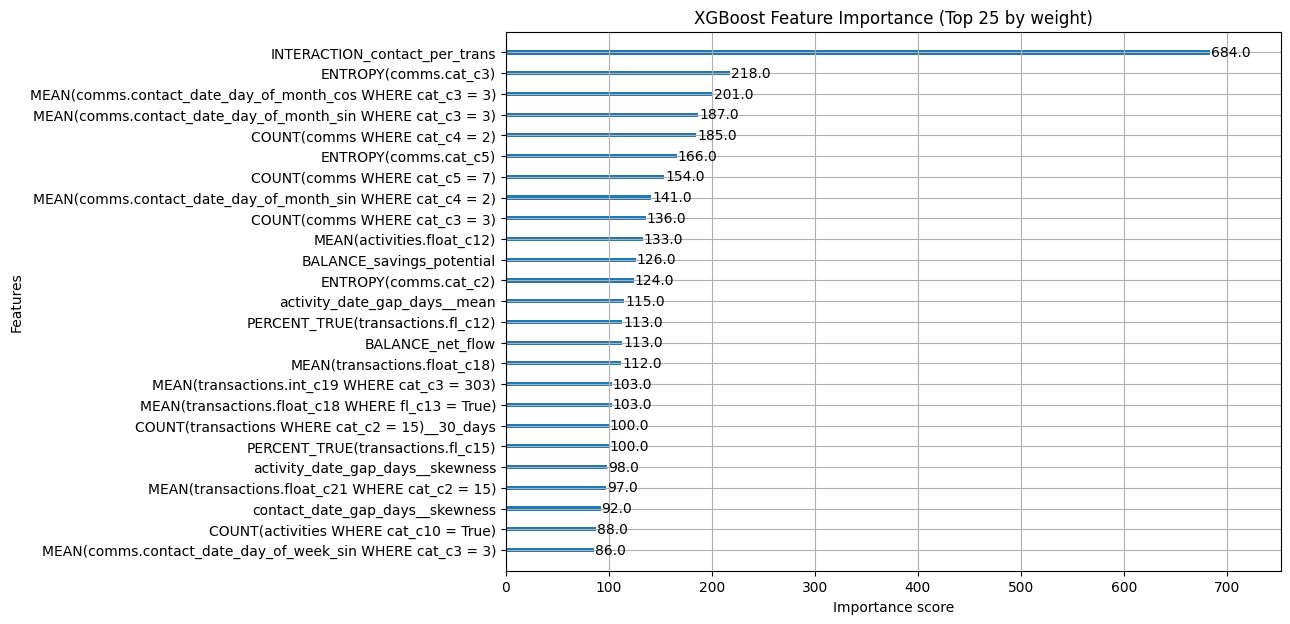

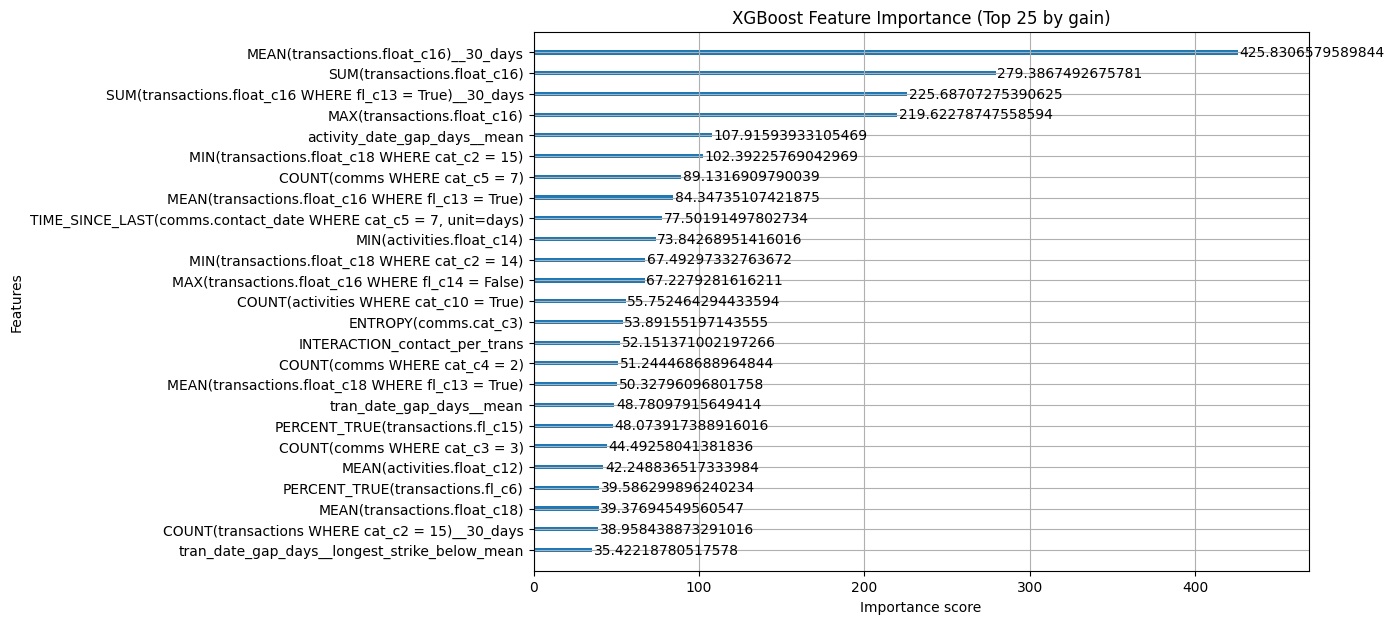

In [48]:
# Feature importance
for imp_type in ('weight', 'gain'):
    fig, ax = plt.subplots(figsize=(10, 7))
    xgb.plot_importance(model, ax=ax, importance_type=imp_type, max_num_features=25)
    plt.title(f'XGBoost Feature Importance (Top 25 by {imp_type})')
    plt.show()